<a href="https://colab.research.google.com/github/Raman-Raje/colab_notebooks/blob/master/craft_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys

!test -d craft || git clone https://github.com/clovaai/CRAFT-pytorch.git craft
if not 'craft' in sys.path:
  sys.path += ['craft']

Cloning into 'craft'...
remote: Enumerating objects: 56, done.
remote: Total 56 (delta 0), reused 0 (delta 0), pack-reused 56
Unpacking objects: 100% (56/56), done.


In [0]:
!wget --header="Host: doc-08-9c-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.113 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,mr;q=0.8" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_43l5bl01hf7ajj9pbvi9mc781o8eeef8_nonce=hu08n57tnureo" --header="Connection: keep-alive" "https://doc-08-9c-docs.googleusercontent.com/docs/securesc/b5uqv17b2incf3fn44fs1ogvlmiajung/tl7p17g1gatcc7netu8s8g9ds330r1m5/1587210150000/05173585031594261940/17935642860705527334/1i2R7UIUqmkUtF0jv_3MXTqmQ_9wuAnLf?e=download&authuser=0&nonce=hu08n57tnureo&user=17935642860705527334&hash=fttjitneftsek7tftm9h93k0vr9j2f7o" -c -O 'craft_ic15_20k.pth'

--2020-04-18 11:43:57--  https://doc-08-9c-docs.googleusercontent.com/docs/securesc/b5uqv17b2incf3fn44fs1ogvlmiajung/tl7p17g1gatcc7netu8s8g9ds330r1m5/1587210150000/05173585031594261940/17935642860705527334/1i2R7UIUqmkUtF0jv_3MXTqmQ_9wuAnLf?e=download&authuser=0&nonce=hu08n57tnureo&user=17935642860705527334&hash=fttjitneftsek7tftm9h93k0vr9j2f7o
Resolving doc-08-9c-docs.googleusercontent.com (doc-08-9c-docs.googleusercontent.com)... 172.217.5.225, 2607:f8b0:4004:804::2001
Connecting to doc-08-9c-docs.googleusercontent.com (doc-08-9c-docs.googleusercontent.com)|172.217.5.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘craft_ic15_20k.pth’

craft_ic15_20k.pth      [      <=>           ]  79.30M  66.0MB/s    in 1.2s    

2020-04-18 11:43:59 (66.0 MB/s) - ‘craft_ic15_20k.pth’ saved [83152330]



In [0]:
import sys
import os
import time
import argparse

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import cv2
from skimage import io
import numpy as np
import craft_utils
import imgproc
import file_utils
import json
import zipfile

from craft import CRAFT
from collections import OrderedDict
import matplotlib.pyplot as plt


In [0]:
cuda = True
refine = True
poly = None
text_threshold = 0.7
link_threshold = 0.4
low_text = 0.4
canvas_size =1280
mag_ratio = 1.5

In [0]:
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")



In [0]:
net = CRAFT()  
net.load_state_dict(copyStateDict(torch.load("/content/craft_ic15_20k.pth")))

if cuda:
  net = net.cuda()
  net = torch.nn.DataParallel(net)
  cudnn.benchmark = False

net.eval()

<All keys matched successfully>

In [0]:
# LinkRefiner
refine_net = None

if refine:
        from refinenet import RefineNet
        refine_net = RefineNet()
        if cuda:
            refine_net.load_state_dict(copyStateDict(torch.load("/content/craft_refiner_CTW1500.pth")))
            refine_net = refine_net.cuda()
            refine_net = torch.nn.DataParallel(refine_net)
        else:
            refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model, map_location='cpu')))

        refine_net.eval()
        poly = True


In [0]:
 t = time.time()

# For test images in a folder
image_list, _, _ = file_utils.get_files("/content/data")

In [0]:
result_folder = '/content/result/'
if not os.path.isdir(result_folder):
    os.mkdir(result_folder)

In [0]:
image_list

['/content/data/starbucks1.jpg',
 '/content/data/starbucks.png',
 '/content/data/dsn.jpg']

In [0]:
def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image,canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)

    return boxes, polys, ret_score_text


In [0]:
image_path = image_list[0]
image = imgproc.loadImage(image_path)

In [0]:
bboxes, polys, score_text = test_net(net, image,text_threshold, link_threshold, low_text, cuda, poly, refine_net)


In [0]:
# save score text
filename, file_ext = os.path.splitext(os.path.basename(image_path))
mask_file = result_folder + "/res_" + filename + '_mask.jpg'
cv2.imwrite(mask_file, score_text)

file_utils.saveResult(image_path, image[:,:,::-1], polys, dirname=result_folder)


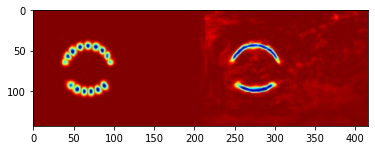

In [0]:
original = cv2.imread(image_list[0])
output = cv2.imread("/content/result/res_starbucks1_mask.jpg")
plt.imshow(output)

In [0]:
 # Find contours 
gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)

threshold = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

contours, hierarchy = cv2.findContours(threshold.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)


In [0]:
# Sort Contors by area and then remove the largest frame contour
contours = sorted(contours, key=cv2.contourArea, reverse=True)
print(len(contours))

  # Iterate through each contour and compute the bounding rectangle
for c in contours:
  x,y,w,h = cv2.boundingRect(c)
  cv2.rectangle(original,(x,y),(x+w,y+h),(0,0,255),2)    


192


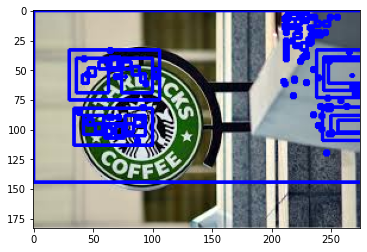

In [0]:
plt.imshow(original)